(transit)=

# Transit Fitting

Unsurprisingly, like `exoplanet`, `jaxoplanet` includes methods for computing the light curves of transiting exoplanets. In this tutorial, we introduce these methods and use it alongside the `NumPyro` probabilistic programming library to do some transit fitting. Parts of this tutorial will follow the [Transit Fitting tutorial](https://gallery.exoplanet.codes/tutorials/transit/) for the `exoplanet` package.

Let's import the necessary packages and configure the setup.

In [61]:
import jaxoplanet
from jaxoplanet.light_curves import LimbDarkLightCurve
from jaxoplanet.orbits import TransitOrbit
import numpy as np
import matplotlib.pyplot as plt
import numpyro
import numpyro_ext.distributions, numpyro_ext.optim
import jax
import jax.numpy as jnp
import corner
import arviz as az

numpyro.set_host_device_count(2)  # For multi-core parallelism (useful when running multiple MCMC chains in parallel)
numpyro.set_platform("cpu")  # For CPU (use "gpu" for GPU)
jax.config.update("jax_enable_x64", True)  # For 64-bit precision since JAX defaults to 32-bit


print(f"jaxoplanet.__version__ = {jaxoplanet.__version__}")
print(f"numpy.__version__ = {np.__version__}")
print(f"matplotlib.__version__ = {plt.matplotlib.__version__}")
print(f"numpyro.__version__ = {numpyro.__version__}")
print(f"numpyro_ext.__version__ = {numpyro_ext.__version__}")
print(f"jax.__version__ = {jax.__version__}")
print(f"corner.__version__ = {corner.__version__}")
print(f"arviz.__version__ = {az.__version__}")

jaxoplanet.__version__ = 0.0.0
numpy.__version__ = 1.24.2
matplotlib.__version__ = 3.7.1
numpyro.__version__ = 0.11.0
numpyro_ext.__version__ = 0.0.2.dev11+gb52b078
jax.__version__ = 0.4.8
corner.__version__ = 2.2.2
arviz.__version__ = 0.15.1


Let's first compute a simple light curve.

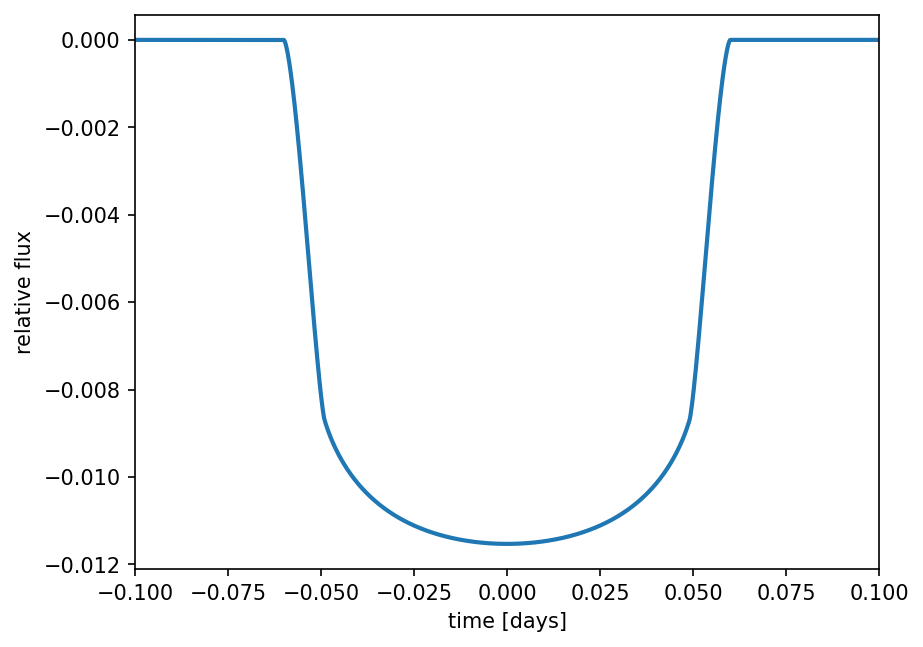

In [62]:
# The light curve calculation requires an orbit object.
# We'll use TransitOrbit (similar to SimpleTransitOrbit in the exoplanet package),
# which is an orbit parameterized by the observables of a transiting system:
# period, speed/duration, time of transit, impact parameter, and radius ratio.
orbit = TransitOrbit.init(
    period=3.456, duration=0.12, time_transit=0.0, impact_param=0.0, radius=0.1
)  # TODO: Is it actually the radius ratio?


# Compute a limb-darkened light curve for this orbit
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = LimbDarkLightCurve.init(u).light_curve(
    orbit, t
)  # returns a 2D array of shape (1, 1000)
light_curve = light_curve[0]  # remove the extra dimension

# Plot the light curve
plt.figure(dpi=150)
plt.plot(t, light_curve, lw=2)
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.xlim(t.min(), t.max());

## Transit model in NumPyro

We'll construct a transit model using `NumPyro` and fit to some simulated data. `NumPyro` is a probabilistic programming library (PPLs) like `PyMC` that allows us to succinctly build models and perform (gradient-based) inference with them. **NumPyro models must be written in JAX!**

TODO for writing: 
1. Bayesian inference, parameter estimation in science
2. NumPyro works with models written using JAX

Let's start off by choosing the transit properties of our simulated data. These will be the "true" values that we would like to recover with our inference. 
<!-- To make our lives easier let's set the impact parameter $b$ to be 0.  -->

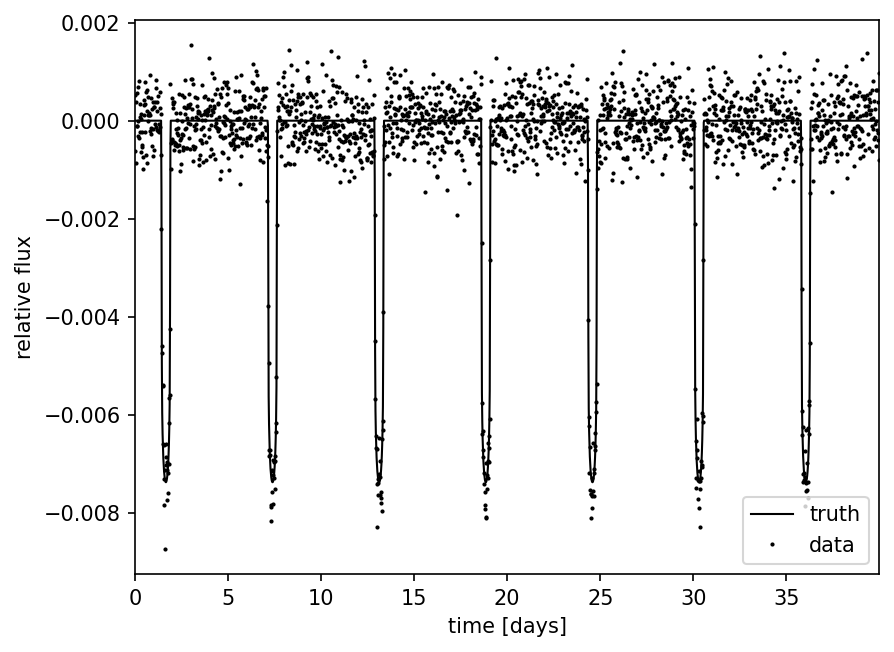

In [70]:
np.random.seed(21)
PERIOD = np.random.uniform(5, 20, 1)[0]  # day
T0 = PERIOD * np.random.rand(1)[0]  # day
DURATION = 0.5  # day
B = 0.1  # impact parameter
ROR = 0.08  # planet radius / star radius <- is this star radius or solar radius?
U = np.array([0.3, 0.2])  # limb darkening coefficients
yerr = 5e-4  # flux uncertainty
t = np.arange(0, 40, 0.02)  # day


orbit = TransitOrbit.init(
    period=PERIOD, duration=DURATION, time_transit=T0, impact_param=B, radius=ROR
)
y_true = LimbDarkLightCurve.init(U).light_curve(orbit, t)[0]
y = y_true + yerr * np.random.randn(len(t))

# Let's see what the light curve looks like
plt.figure(dpi=150)
plt.plot(t, y_true, "-k", lw=1.0, label="truth")
plt.plot(t, y, ".k", ms=2, label="data")
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.xlim(t.min(), t.max())
plt.legend(loc=4);

Let's define our numpyro model. The syntax for numpyro might be a bit unfamiliar, but here it is. 

In [71]:
def model(t, yerr, y=None):
    # Priors for the parameters we're fitting for

    # The time of reference transit
    t0 = numpyro.sample("t0", numpyro.distributions.Normal(T0, 1))

    # The period.
    logP = numpyro.sample("logP", numpyro.distributions.Normal(jnp.log(PERIOD), 0.1))
    period = numpyro.deterministic("period", jnp.exp(logP))

    # The duration.
    logD = numpyro.sample("logD", numpyro.distributions.Normal(jnp.log(DURATION), 0.1))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # The radius ratio
    # logR = numpyro.sample("logR", numpyro.distributions.Normal(jnp.log(ROR), 0.1))
    r = numpyro.sample("r", numpyro.distributions.Uniform(0.01, 0.2))
    # r = numpyro.deterministic("r", jnp.exp(logR))

    # The impact parameter
    _b = numpyro.sample("_b", numpyro.distributions.Uniform(0, 1))
    b = numpyro.deterministic("b", _b * (1 + r))

    # The limb darkening coefficients
    u = numpyro.sample("u", numpyro_ext.distributions.QuadLDParams())

    # The orbit and light curve
    orbit = TransitOrbit.init(
        period=period, duration=duration, time_transit=t0, impact_param=b, radius=r
    )
    y_pred = LimbDarkLightCurve.init(u).light_curve(orbit, t)[0]

    # Let's track the light curve
    numpyro.deterministic("light_curve", y_pred)

    # The likelihood function assuming known Gaussian uncertainty
    numpyro.sample("obs", numpyro.distributions.Normal(y_pred, yerr), obs=y)

TODO: Explain why we're sampling in log space. Explain the impact parameter sampling. <- this only works for when there's one radius we care about.

It can be a good idea to see whether the priors we defined are reasonable by sampling and plotting them. Let's do that now using the `numpyro.infer` submodule's `Predictive` functionality.

In [72]:
n_prior_samples = 3000
prior_samples = numpyro.infer.Predictive(model, num_samples=n_prior_samples)(
    jax.random.PRNGKey(0), t, yerr
)

# Let's make it into an arviz InferenceData object.
# To do so we'll first need to reshape the samples to be of shape (chains, draws, *shape)
converted_prior_samples = {
    f"{p}": np.expand_dims(prior_samples[p], axis=0) for p in prior_samples
}
prior_samples_inf_data = az.from_dict(converted_prior_samples)

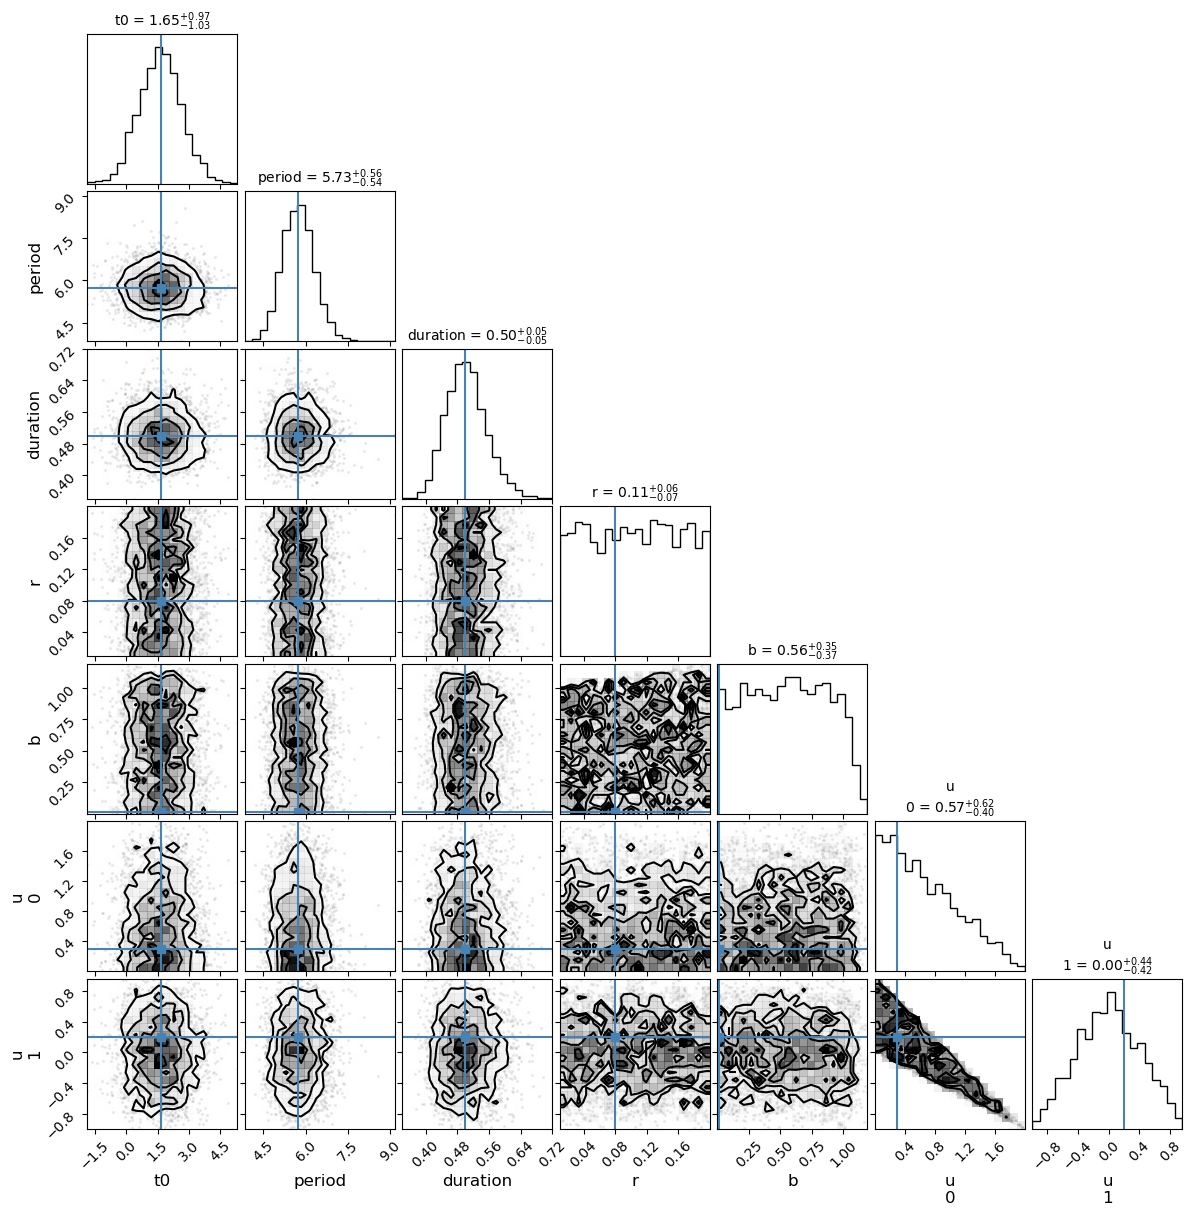

In [73]:
# Plot the corner plot
fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    prior_samples_inf_data,
    fig=fig,
    var_names=["t0", "period", "duration", "r", "b", "u"],
    truths=[T0, PERIOD, DURATION, ROR, B, U[0], U[1]],
    show_titles=True,
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 12},
)

These priors seems sensible enough. Before we start sampling, let's find the maximum a posteriori (MAP) solution. This is a good starting point for the sampling we'll perform later and also a good check to see if things are working.
We'll use the optim module within the `numpyro_ext` package.

We have a choice for the inital value of the optimization. Some potential options include:
1. Manually setting them to a specific set of values. This approach might make sense for real data when it's of a system that's been studied before and there's a good guess for the parameters. As an example, if one was fitting some follow-up ground-based transit data it might make sense to use the parameters from a Kepler/TESS discovery paper as the initial values.
2. The median values of the priors. This might be a good idea when we don't have a good guess for the parameters. Similarly, we could also use the mean values of the priors.

Let's do the former and set the initial values to the true values. 
<!-- Let's do the latter and set the initial values to the median values of the priors. -->

In [74]:
init_param_method = "true_values"  # "prior_median" or "true_values"

if init_param_method == "prior_median":
    print("Starting from the prior medians")
    run_optim = numpyro_ext.optim.optimize(
        model, num_steps=50, init_strategy=numpyro.infer.init_to_median()
    )
elif init_param_method == "true_values":
    print("Starting from the true values")
    init_params = {
        "t0": T0,
        "logP": jnp.log(PERIOD),
        "logD": jnp.log(DURATION),
        "logR": jnp.log(ROR),
        "_b": B / (1 + ROR),
        "u": U,
    }
    run_optim = numpyro_ext.optim.optimize(
        model,
        num_steps=10,
        init_strategy=numpyro.infer.init_to_value(values=init_params),
    )

opt_params = run_optim(jax.random.PRNGKey(5), t, yerr, y=y)

Starting from the true values


In [75]:
opt_params

{'t0': Array(1.6553024, dtype=float64),
 'logP': Array(1.74594642, dtype=float64),
 'logD': Array(-0.69236413, dtype=float64),
 'r': Array(0.08016516, dtype=float64),
 '_b': Array(1.02220189e-06, dtype=float64),
 'u': Array([0.32482148, 0.18913257], dtype=float64),
 'b': Array(1.10414687e-06, dtype=float64),
 'duration': Array(0.50039168, dtype=float64),
 'light_curve': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'obs': Array([ 0.0005209 , -0.00062837,  0.00037269, ..., -0.00024153,
        -0.00080588,  0.00096685], dtype=float64),
 'period': Array(5.73132315, dtype=float64)}

Now let's plot the MAP model against the simulated data.

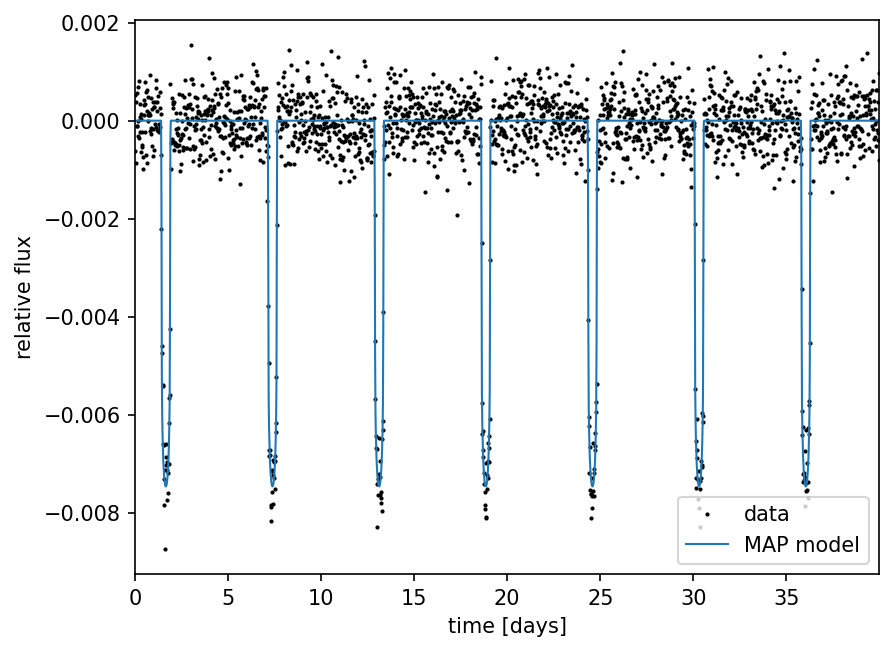

In [76]:
plt.figure(dpi=150)
plt.plot(t, y, ".k", ms=2, label="data")
plt.plot(t, opt_params["light_curve"], lw=1.0, label="MAP model")
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.legend(fontsize=10, loc=4)
plt.xlim(t.min(), t.max());

Great. Not surprisingly, the MAP model is  a good fit to the data.
Let's use these MAP values as the initial values for our sampling.

## Sampling
Let's sample from the posterior defined by this model. We'll use the No-U-Turn Sampler (NUTS) algorithm, which is a Hamiltonian Monte Carlo (HMC) algorithm.

In [24]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        model,
        dense_mass=True,
        init_strategy=numpyro.infer.init_to_value(values=opt_params),
    ),
    num_warmup=500,
    num_samples=1000,
    num_chains=2,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(0), t, yerr, y=y)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

We should check the convergence of our sampler. Determining whether a sampler has converged is a non-trivial task and there is a lot of literature on the subject. We'll attempt to check for convergence by looking at the the Gelman-Rubin $\hat{r}$ statistic and the estimate for the bulk effective sample size (ESS) of each parameter. 

- [The $\hat{R}$ statistic](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html) is a diagnostic of convergence based on the ratio of the variance between chains to the variance within chains. We would like for it to be close to 1.00 for each parameter. 
- The [ESS](https://mc-stan.org/docs/2_18/reference-manual/effective-sample-size-section.html) is a measure of the number of independent samples in the chains and is inversely correlated with the autocorrelation in a chain. Larger estimates for the ESS are better as they indicate less autocorrelation in the chains.

We can get both of these values using the `summary` function in the `Arviz` package. Let's do that now.

In [25]:
inf_data = az.from_numpyro(sampler)
samples = sampler.get_samples()
az.summary(inf_data, var_names=["t0", "period", "duration", "r", "b", "u"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t0,1.655,0.001,1.653,1.657,0.000,0.000,2319.0,1316.0,1.00
period,5.731,0.000,5.731,5.732,0.000,0.000,2071.0,1684.0,1.00
duration,0.502,0.003,0.496,0.507,0.000,0.000,833.0,1035.0,1.00
r,0.080,0.001,0.079,0.082,0.000,0.000,444.0,595.0,1.00
b,0.169,0.108,0.000,0.344,0.006,0.004,309.0,484.0,1.01
u[0],0.322,0.101,0.137,0.516,0.004,0.003,798.0,921.0,1.00
u[1],0.191,0.193,-0.141,0.563,0.007,0.005,664.0,684.0,1.00


The ESS (`ess_bulk`) isn't great for some of the parameters, like the impact parameter $b$, but since the $\hat{R}$ values are good let's just ahead with these samples. In practice you probably want to run the sampler for longer to get better ESS values.

Let's get a different view of the chains by making some trace plots.

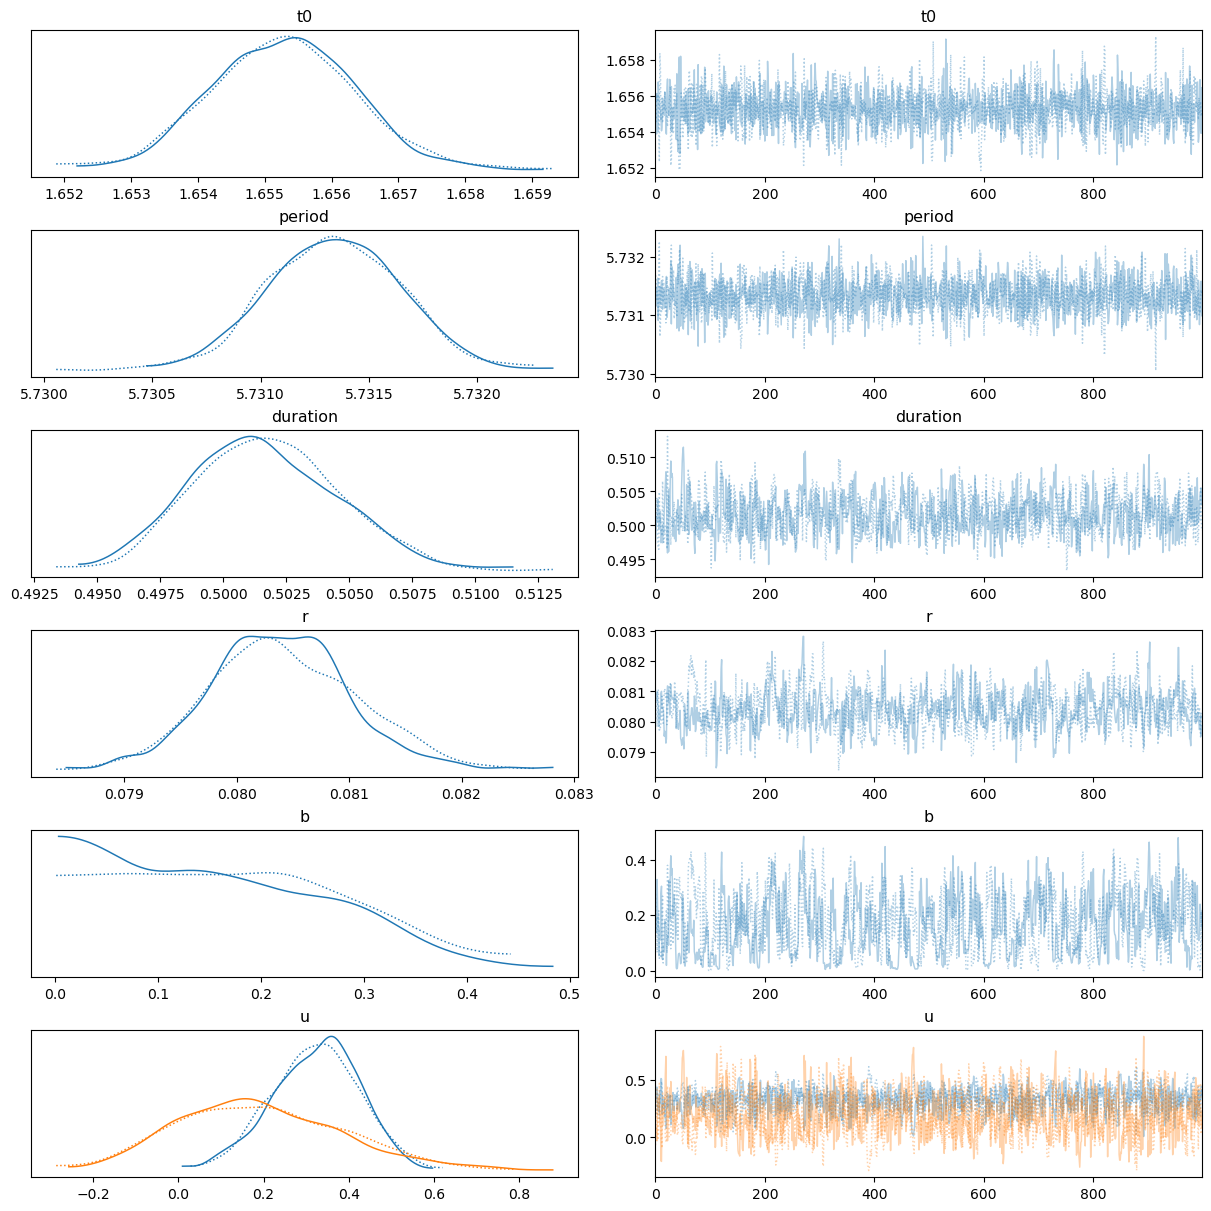

In [26]:
az.plot_trace(
    inf_data,
    var_names=["t0", "period", "duration", "r", "b", "u"],
    backend_kwargs={"constrained_layout": True},
);

The different line styles above indicate the two parallel chains. There's two colors for $u$ since there are two limb-darkening coefficients (i.e., $u_1, u_2$).

Let's now make a corner plot of the posterior samples to see the pairwise joint distributions of the parameters and see if there are any correlations.

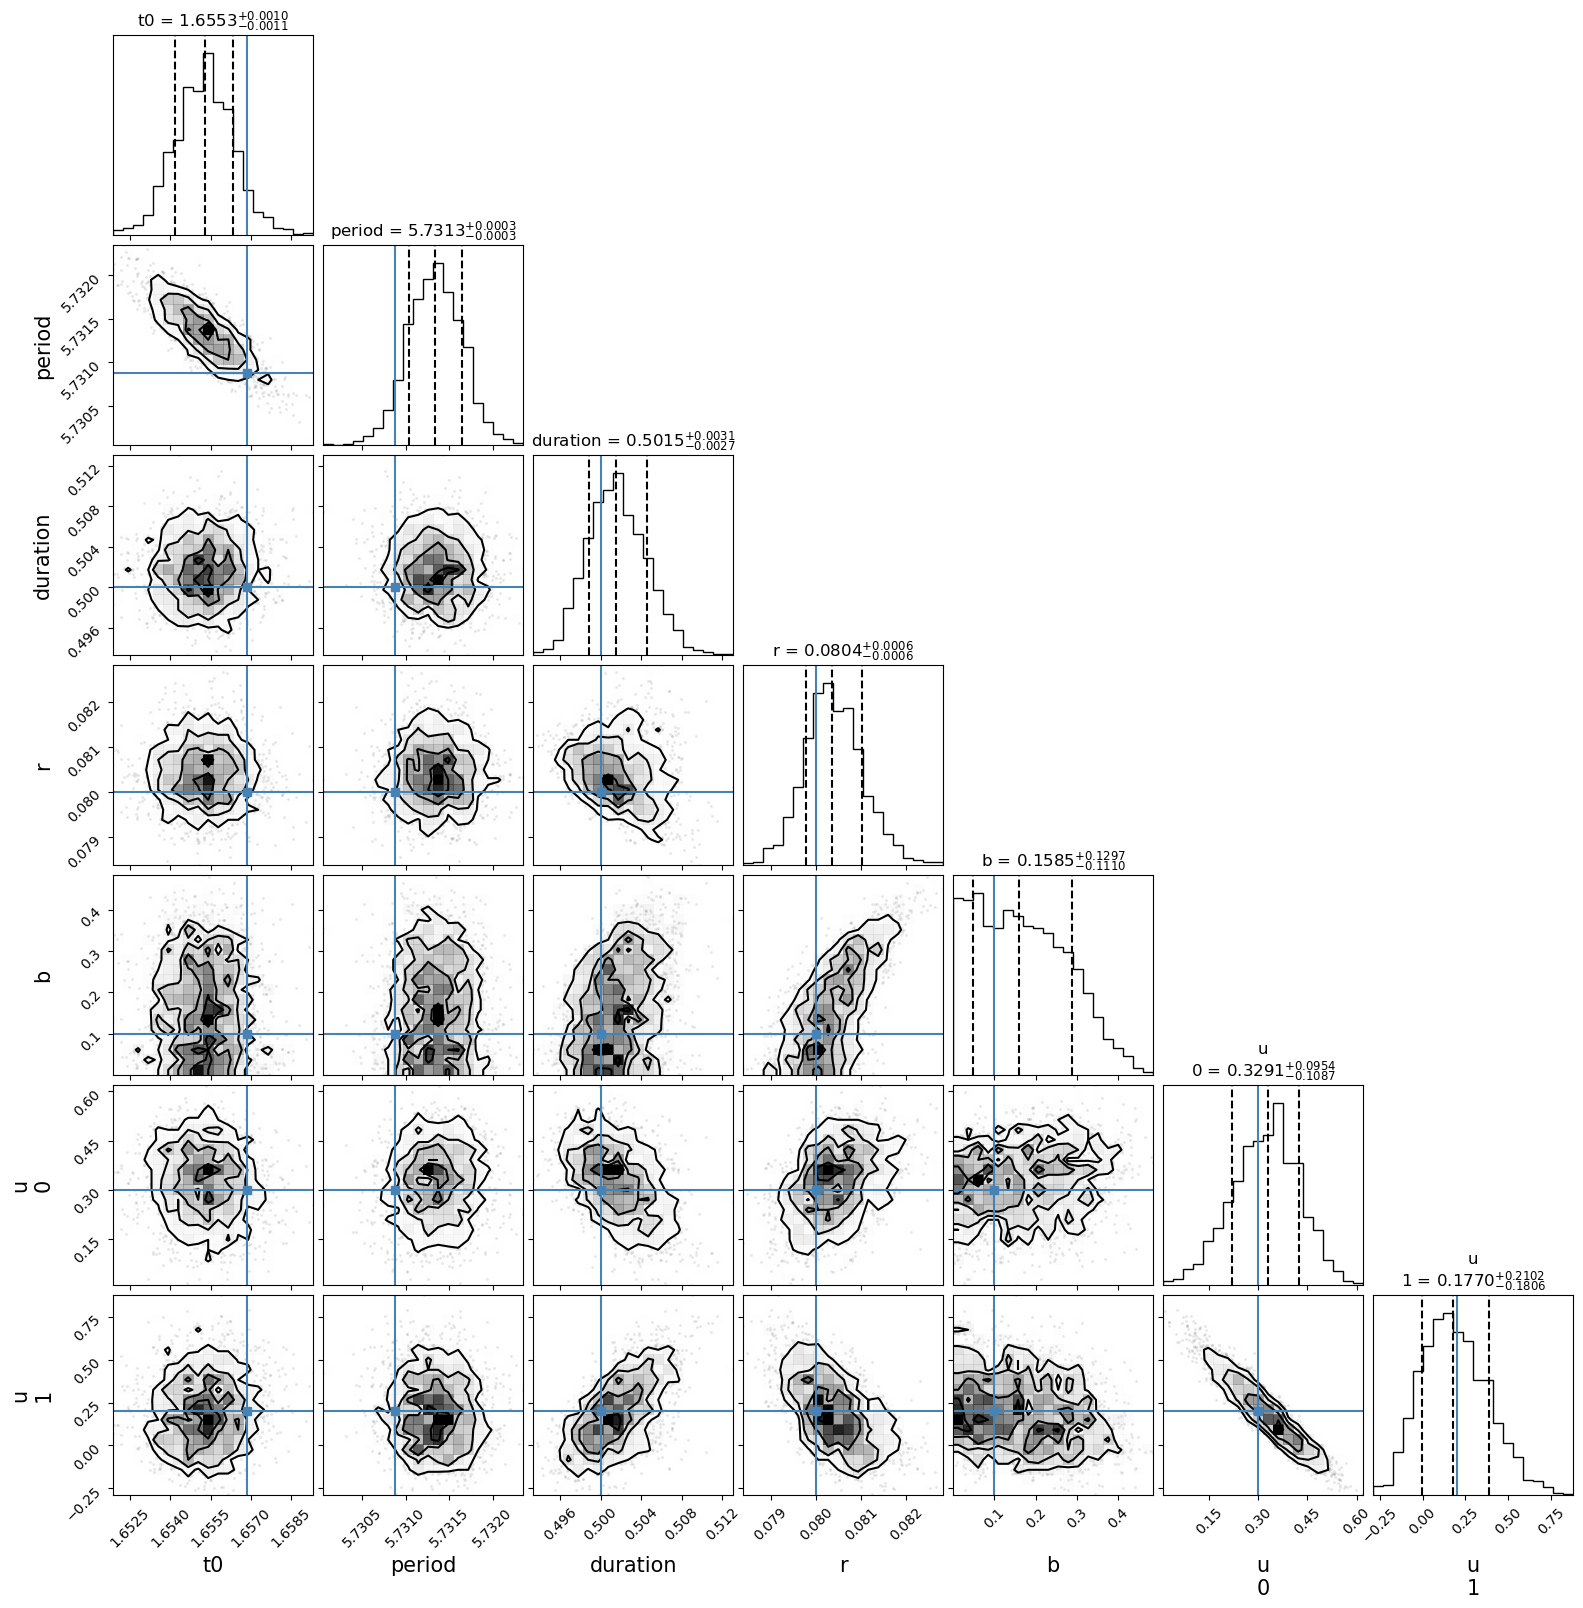

In [27]:
corner.corner(
    inf_data,
    var_names=["t0", "period", "duration", "r", "b", "u"],
    truths=[T0, PERIOD, DURATION, ROR, B, U[0], U[1]],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 15},
    title_fmt=".4f",
);

## Phase plots
Let's make the phase plot that is commonly shown in exoplanet papers.

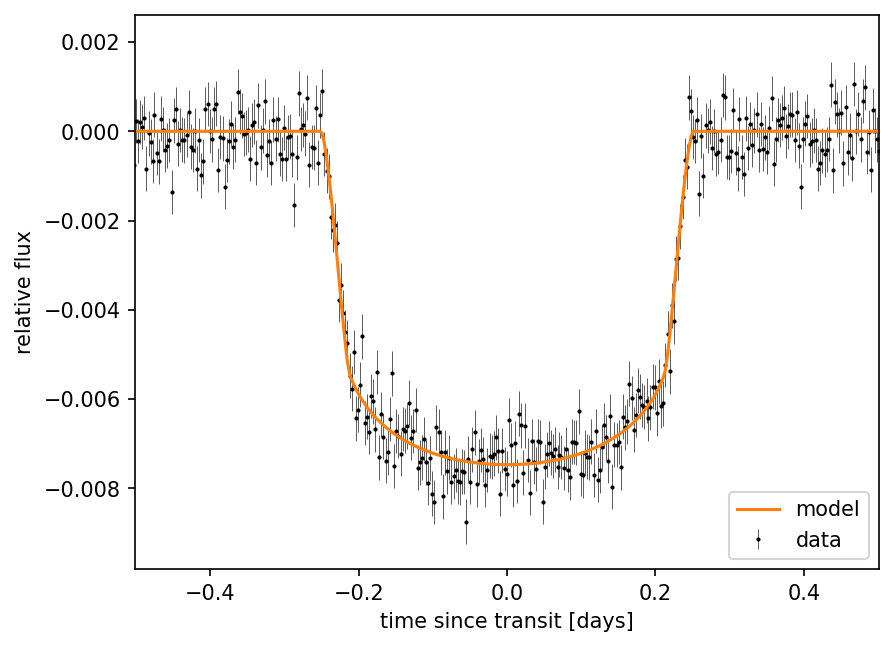

In [99]:
inferred_t0 = np.median(samples["t0"])
inferred_period = np.median(samples["period"])
inferred_duration = np.median(samples["duration"])
inferred_r = np.median(samples["r"])
inferred_b = np.median(samples["b"])
inferred_u = np.median(samples["u"], axis=0)

orbit = TransitOrbit.init(
    period=inferred_period,
    duration=inferred_duration,
    time_transit=inferred_t0,
    impact_param=inferred_b,
    radius=inferred_r
)
y_model = LimbDarkLightCurve.init(inferred_u).light_curve(orbit, t)[0]

fig, ax = plt.subplots(dpi=150)

# Plot the folded data
t_fold = (t - t0 + 0.5 * inferred_period) % inferred_period - 0.5 * inferred_period
ax.errorbar(t_fold, y, yerr=yerr, marker='.', ls='none', color='k', capsize=0, ms=2, lw=0.3, alpha=1, label="data", zorder=-100)

# Plot the folded model
inds = np.argsort(t_fold)
ax.plot(t_fold[inds], y_model[inds], color='C1', lw=1.5, label="model")
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("relative flux")
ax.legend(fontsize=10, loc=4)
ax.set_xlim(-inferred_duration, inferred_duration);